In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string

In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

## Data processing

In [3]:
train_df = pd.read_csv('archive/sign_mnist_train/sign_mnist_train.csv')
test_df = pd.read_csv('archive/sign_mnist_test/sign_mnist_test.csv')

letters = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']

y_train = torch.from_numpy(train_df['label'].to_numpy())
y_train = torch.from_numpy(np.array([x if x<10 else x-1 for x in y_train]))
train_df = train_df.drop('label', axis = 1)

X_train = torch.from_numpy(train_df.to_numpy())

y_test = torch.from_numpy(test_df['label'].to_numpy())
y_test = torch.from_numpy(np.array([x if x<10 else x-1 for x in y_test]))
test_df = test_df.drop('label', axis = 1)

X_test = torch.from_numpy(test_df.to_numpy())

In [4]:
data_transform = transforms.Compose([
    #transforms.RandomResizedCrop(new_size, scale=(0.90,1), antialias=True),
    #transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.1), scale=(1, 1)),
    #transforms.transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
    transforms.RandomRotation(degrees=10),
    ])


In [5]:
aug_ratio = 5
X_train_aug = X_train
y_train_aug = y_train

for a in range(aug_ratio):
    aug = data_transform(X_train.view(len(X_train),1,28,28))
    p = torch.rand(size=(len(aug),1))*0.5+1
    tmp = torch.pow(aug.view(len(X_train),28*28),p)
    #tmp = aug.view(len(X_train),28*28)
    X_train_aug = torch.cat((X_train_aug,tmp), dim=0)
    y_train_aug = torch.cat((y_train_aug,y_train), dim=0)

<BarContainer object of 24 artists>

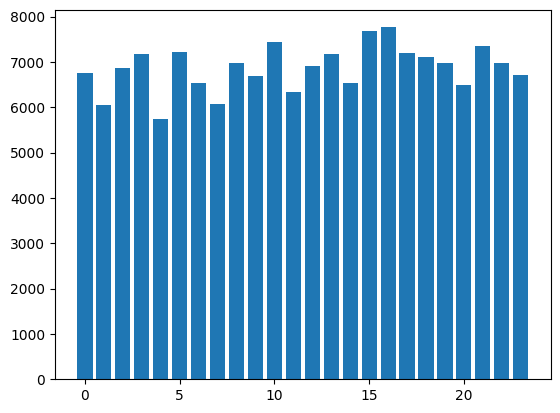

In [6]:
lab, counts= np.unique(y_train_aug, return_counts=True)
plt.bar(lab, counts)

<BarContainer object of 24 artists>

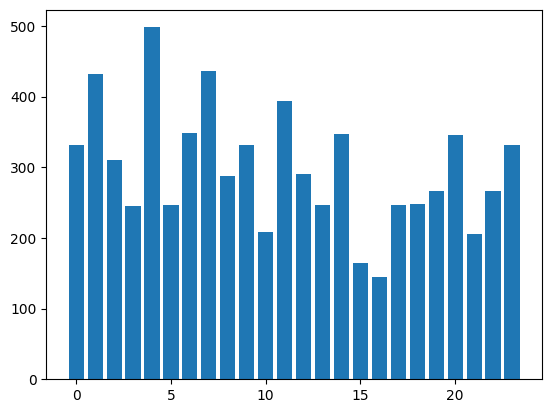

In [7]:
lab, counts= np.unique(y_test, return_counts=True)
plt.bar(lab, counts)

## Visualize and Normalize data

In [8]:
def ImgShow(i, X, y, test=False):
    if not test:

        plt.imshow(X[i].view(28,28), cmap='gray')
        lab = letters[y[i]]
        plt.title(f'Image n.{i},  label: {lab}')
        plt.show()

    else:

        plt.imshow(X[i].view((28,28)), cmap='gray')
        pred = letters[torch.argmax(cnn(X[i].view(1,1,28,28)))]
        lab = letters[y[i]]
        plt.title(f'Image n.{i}, true label: {lab}, pred labe: {pred}')
        plt.show() 

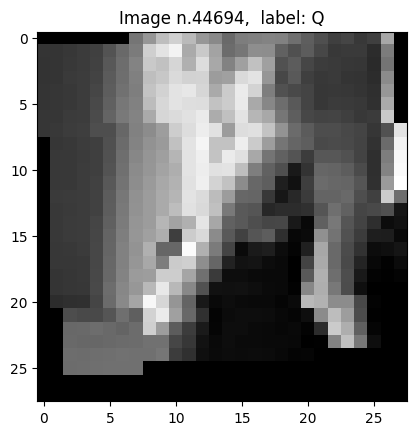

In [9]:
ImgShow( torch.randint(low=0,high=len(X_train_aug), size=(1,)).item(), X_train_aug, y_train_aug)  

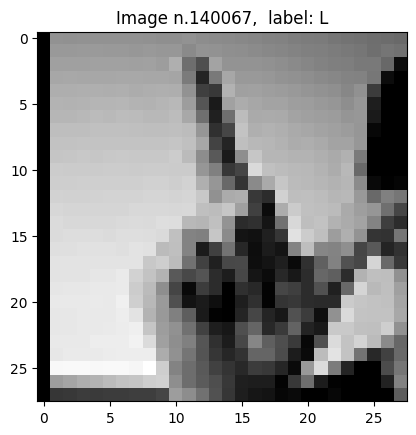

In [10]:
ImgShow(torch.randint(low=0,high=len(X_train_aug), size=(1,)).item(), X_train_aug, y_train_aug)  

In [11]:
def Normalize(X):
    mean = X.float().mean(dim=1, keepdim= True)
    std = X.float().std(dim=1, keepdim= True)
    return (X - mean)/std

In [12]:
X_train_norm = Normalize(X_train_aug)
X_test_norm = Normalize(X_test)

train_size = int(0.9*len(X_train_aug))
X_val, y_val = X_train_norm[train_size:],  y_train_aug[train_size:]

X_train_norm, y_train = X_train_norm[:train_size], y_train_aug[:train_size]

## Definition of the model

In [13]:
class ASL_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3,3), padding=1)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(5,5), padding=2)
        self.conv3 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(5,5), padding=2)
        self.maxpool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(90 ,64)
        self.batchnormL = nn.BatchNorm1d(64)
        self.out = nn.Linear(64,24)
        self.drop = nn.Dropout(0.05)

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)) + self.drop(x))
        x = self.maxpool(F.relu(self.conv2(x)) + self.drop(x)) 
        x = self.maxpool(F.relu(self.conv3(x)) + self.drop(x)) 
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x)) 
        x = self.drop(x)
        x = self.batchnormL(x) 
        x = self.out(x)
        
        return x

cnn = ASL_CNN().to(device)

print('The model has', sum(p.numel() for p in cnn.parameters() if p.requires_grad), 'trainable parameters' )

The model has 12632 trainable parameters


In [14]:
CELoss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.3, total_iters=100)

## Training procedure

In [15]:
gen = torch.manual_seed(123)

batch = 32
loss_eval = 800
tot_epochs = 3
train_history = []
val_history = []

for epoch in range(tot_epochs):

    running_loss = 0.0
    running_val_loss = 0.0
    for i in range(len(X_train_norm)//batch):
        
        # Batch of training 
        ix = torch.randint(0, len(X_train_norm), (batch,1), generator=gen)
        ixv = torch.randint(0, len(X_val), (batch,1), generator=gen)
        
        #
        cnn.train()
        out = cnn(X_train_norm[ix].view(batch,1,28,28).to(device))
        loss = CELoss(out, y_train_aug[ix].view(batch).to(device))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        cnn.eval()
        with torch.no_grad():
            out = cnn(X_val[ixv].view(batch,1,28,28).to(device))
            loss_val = CELoss(out, y_val[ixv].view(batch).to(device))
            running_val_loss += loss_val.item()
            running_loss += loss.item() 

        scheduler.step()


        if i % loss_eval == loss_eval-1:
            print(f'(epoch: {epoch}), sample: {batch*(i+1)}, ---> train loss={running_loss/loss_eval:.5f} || val loss={running_val_loss/loss_eval:.5f}')
            train_history.append(running_loss)
            val_history.append(running_val_loss)
            running_loss = 0.0
            running_val_loss = 0.0

(epoch: 0), sample: 25600, ---> train loss=1.27169 || val loss=1.29725
(epoch: 0), sample: 51200, ---> train loss=0.46125 || val loss=0.38949
(epoch: 0), sample: 76800, ---> train loss=0.32587 || val loss=0.24156
(epoch: 0), sample: 102400, ---> train loss=0.25324 || val loss=0.17426
(epoch: 0), sample: 128000, ---> train loss=0.21181 || val loss=0.13210
(epoch: 1), sample: 25600, ---> train loss=0.16316 || val loss=0.08038
(epoch: 1), sample: 51200, ---> train loss=0.14578 || val loss=0.08633
(epoch: 1), sample: 76800, ---> train loss=0.14305 || val loss=0.07170
(epoch: 1), sample: 102400, ---> train loss=0.11805 || val loss=0.05974
(epoch: 1), sample: 128000, ---> train loss=0.13612 || val loss=0.07630
(epoch: 2), sample: 25600, ---> train loss=0.10759 || val loss=0.05041
(epoch: 2), sample: 51200, ---> train loss=0.10551 || val loss=0.04425
(epoch: 2), sample: 76800, ---> train loss=0.09359 || val loss=0.03685
(epoch: 2), sample: 102400, ---> train loss=0.09333 || val loss=0.03658
(

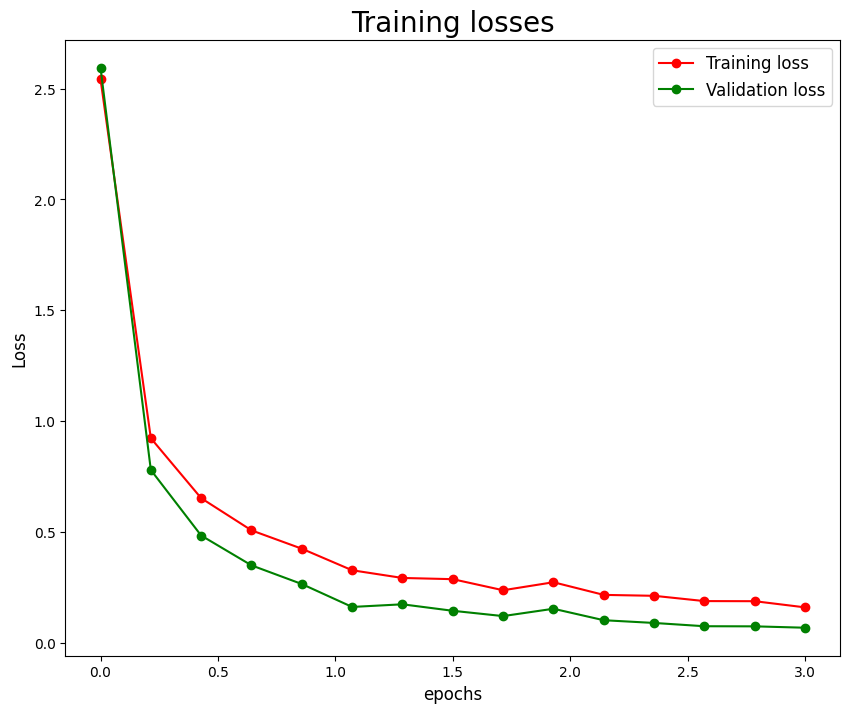

In [16]:
plt.figure(figsize=(10,8))
plt.plot(np.linspace(0,3,15), np.array(train_history)/400, label='Training loss', marker='o', linestyle='-', color='red')
plt.plot(np.linspace(0,3,15), np.array(val_history)/400, label='Validation loss', marker='o', linestyle='-', color='green')
plt.xlabel('epochs',  fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize='large')
plt.title('Training losses', fontsize=20)
plt.show()

## Model's accuracy evaluation

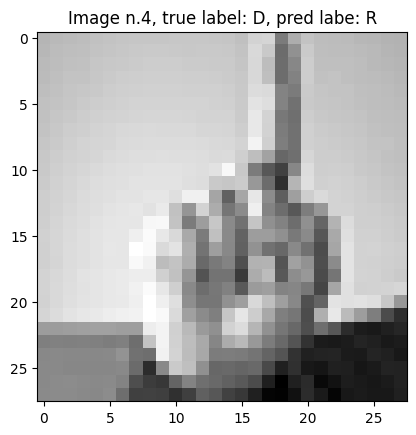

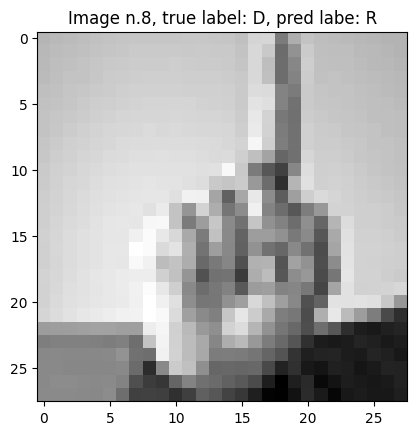

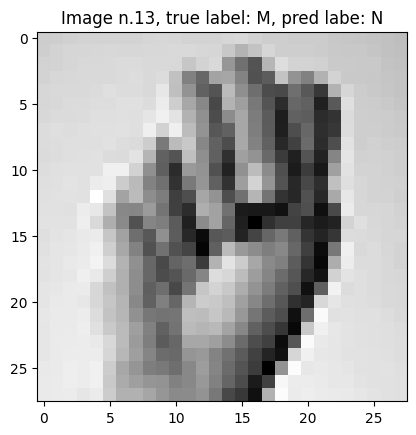

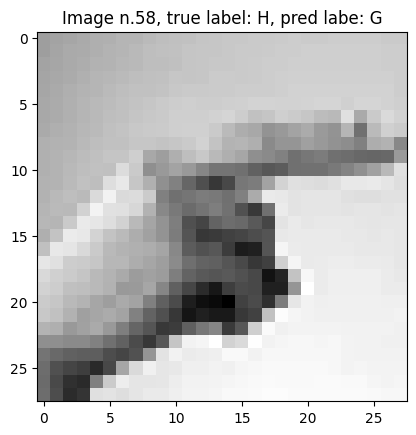

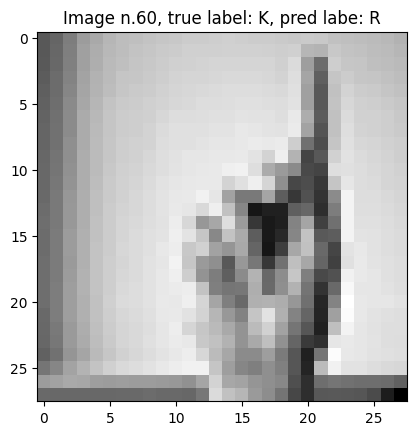

Test Accuracy of the model on test images: 93.962632%


In [17]:
cnn.eval()  
correct = 0
j = 0

cnn.to('cpu')

for i in range(len(X_test_norm)):
    image = X_test_norm[i]
    label = y_test[i]
    out = cnn(image.view(1,1,28,28))
    pred = torch.argmax(out)
    if pred == label:
        correct += 1
    else:
        if j < 5:
            ImgShow(i, X_test_norm, y_test, True)
            j += 1
        

print('Test Accuracy of the model on test images: %.6f%%' % (100.0*correct/len(y_test)))

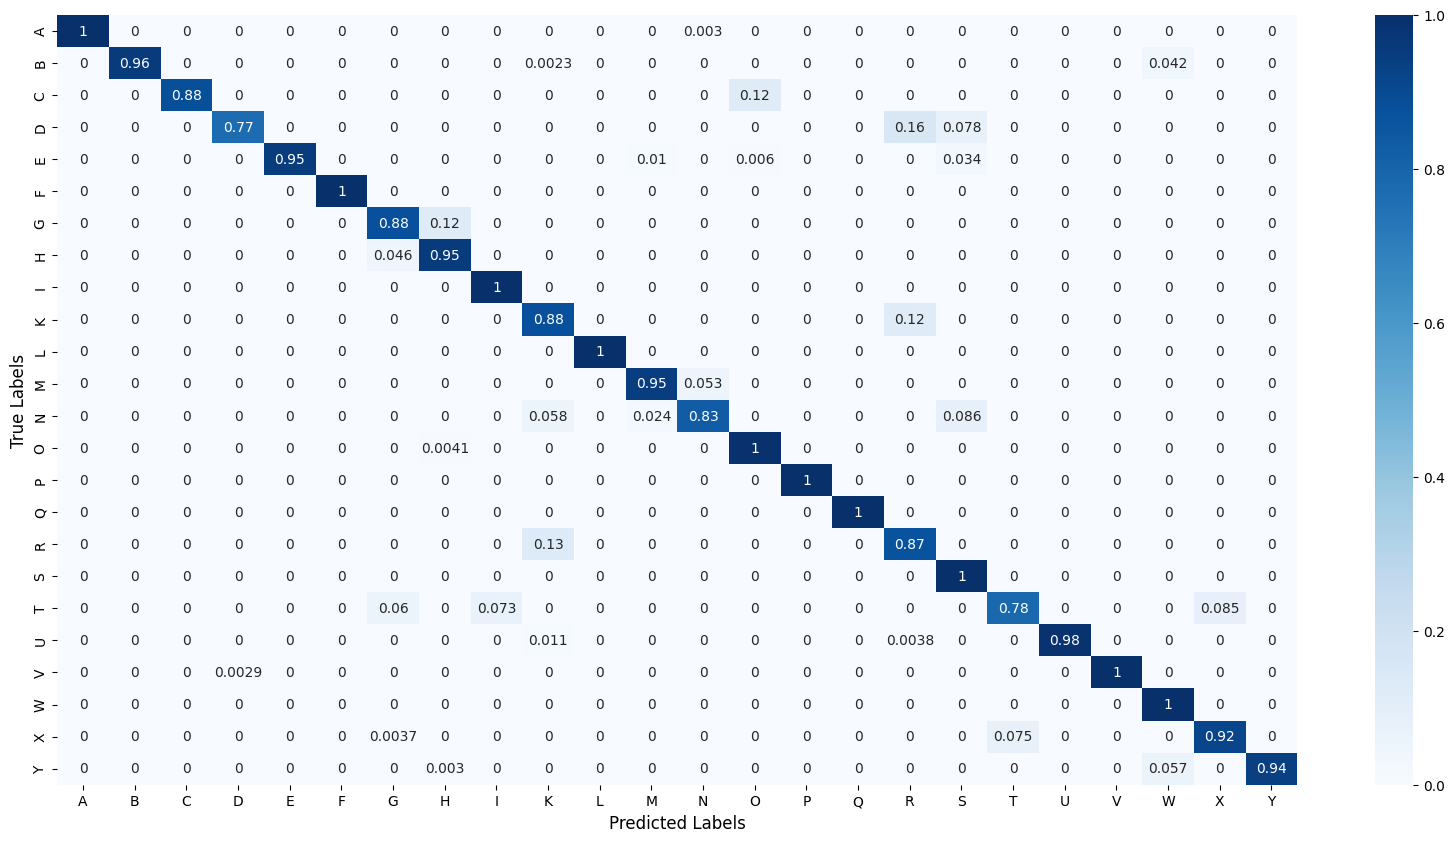

In [22]:
from torchmetrics.classification import ConfusionMatrix

letters = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']

out = cnn(X_test_norm.view(len(X_test),1,28,28))
y_pred = torch.argmax(out, dim=1)

metric = ConfusionMatrix(task="multiclass", num_classes=24, normalize='true')
cf = metric(y_pred, y_test)

import seaborn as sb

plt.figure(figsize=(20,10))
sb.heatmap(cf, annot=True, xticklabels=letters, yticklabels=letters, cmap='Blues' )
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.show()

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       1.00      0.96      0.98       432
           2       1.00      0.88      0.94       310
           3       0.99      0.77      0.87       245
           4       1.00      0.95      0.97       498
           5       1.00      1.00      1.00       247
           6       0.89      0.88      0.89       348
           7       0.90      0.95      0.93       436
           8       0.94      1.00      0.97       288
           9       0.88      0.88      0.88       331
          10       1.00      1.00      1.00       209
          11       0.97      0.95      0.96       394
          12       0.92      0.83      0.87       291
          13       0.86      1.00      0.92       246
          14       1.00      1.00      1.00       347
          15       1.00      1.00      1.00       164
          16       0.61      0.87      0.72       144
          17       0.80    

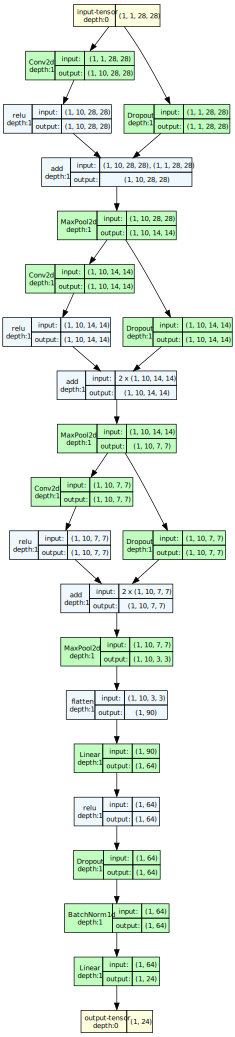

In [20]:
from torchview import draw_graph
import graphviz

model_graph = draw_graph(cnn, input_size=(1,1,28,28), expand_nested=True)
model_graph.visual_graph

In [21]:
HLT

NameError: name 'HLT' is not defined

In [ ]:
import cv2 
import mediapipe as mp

mp_hands = mp.solutions.hands
hands = mp_hands.Hands()

font = cv2.FONT_HERSHEY_SIMPLEX
capture = cv2.VideoCapture(0)

offset = 150

if not capture.isOpened():
    exit(0)
while True:
    ret, frame = capture.read()
    
    frame = cv2.flip(frame, 1)
    results = hands.process(frame)

    # Check if hands are detected
    if results.multi_hand_landmarks:
        for landmarks in results.multi_hand_landmarks:
            # Convert normalized hand landmarks to pixel coordinates
            h, w, _ = frame.shape
            hand_landmarks = [(int(lm.x * w), int(lm.y * h)) for lm in landmarks.landmark]

            # Get bounding box coordinates
            x_min, y_min = min(hand_landmarks, key=lambda x: x[0])[0]-offset, min(hand_landmarks, key=lambda x: x[1])[1]-offset
            x_max, y_max = max(hand_landmarks, key=lambda x: x[0])[0]+offset, max(hand_landmarks, key=lambda x: x[1])[1]+offset

            # Draw a rectangle around the hand
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

            #print(x_min,x_max,y_min,y_max)

            frame_hand = frame[y_min:y_max, x_min:x_max]
    
            img = cv2.resize(cv2.cvtColor(frame_hand, cv2.COLOR_BGR2GRAY), (28,28))
            frame_cnn = transforms.ToTensor()(img)
            letter = string.ascii_uppercase[torch.argmax(cnn(frame_cnn.view(1,1,28,28)))]

            cv2.putText(frame,  
                    letter,  
                    (50, 220),  
                    font, 4,  
                    (0, 0, 255),  
                    4,  
                    cv2.LINE_4)  
            cv2.imshow('Hand Crop', img)   
            
    cv2.imshow('American Sign Language', frame)
    
    if cv2.waitKey(1) == ord('q'):
          break

capture.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

I0000 00:00:1707320885.096337       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M2 Pro


-1

In [ ]:
capture.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1